In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os
import re
%matplotlib inline


In [2]:
def load_production_data(data_path="./"):
    
    production_train = []
    train_files = sorted(os.listdir(data_path+"/TrainingDataProduction/TrainingDataProduction"))
    train_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    for file in train_files:
        temp = pd.read_csv(data_path+"/TrainingDataProduction/TrainingDataProduction/"+file, sep=";")
        temp["ProcessCycle"] = int(file.split('.')[0])
        production_train.append(temp)

    production_train = pd.concat(production_train)

    production_valid = []
    valid_files = sorted(os.listdir(data_path+"/ValidationDataProduction/ValidationDataProduction"))
    valid_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    for file in valid_files:
        temp = pd.read_csv(data_path+"/ValidationDataProduction/ValidationDataProduction/"+file, sep=";")
        temp["ProcessCycle"] = int(file.split('.')[0])
        production_valid.append(temp)

    production_valid = pd.concat(production_valid)
    
    production_test = []

    test_files = sorted(os.listdir(data_path+"/EvaluationDataProduction/EvaluationDataProduction"))
    test_files.sort(key=lambda f: int(re.sub('\D', '', f)))
    for file in test_files:
        temp = pd.read_csv(data_path+"/EvaluationDataProduction/EvaluationDataProduction/"+file, sep=";")
        temp["ProcessCycle"] = int(file.split('.')[0])
        production_test.append(temp)

    production_test = pd.concat(production_test)
    
    cols_with_no_variance_train = []
    cols_with_no_variance_valid = []

    for col in production_train.columns:
        if len(production_train[col].unique()) == 1:
            cols_with_no_variance_train.append(col)

    for col in production_valid.columns:
        if len(production_valid[col].unique()) == 1:
            cols_with_no_variance_valid.append(col)

    common_cols_with_no_variance = list(set(cols_with_no_variance_train) & set(cols_with_no_variance_valid))

    production_train = production_train.drop(common_cols_with_no_variance, axis = 1)
    production_valid = production_valid.drop(common_cols_with_no_variance, axis = 1)
    production_test = production_test.drop(common_cols_with_no_variance, axis = 1)

    production_train["Split"] = "Train"
    production_valid["Split"] = "Valid"
    production_test["Split"] = "Test"
    
    
    production_train_val_combined = pd.concat([production_train, production_valid]).reset_index(drop=True)
    
    return production_train_val_combined, production_test

In [6]:
df_train, df_test = load_production_data()
train, valid = df_train, df_test

In [7]:
#Erstellen von Dummies, um numerische Werte zu erhalten
split = pd.get_dummies(train['Split'],drop_first=True)

train.drop(["Split"],axis=1,inplace=True)
train = pd.concat([train,split],axis=1)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
#Init von Trainings- und Testdaten
X_train, X_test, y_train, y_test = train_test_split(train.drop('Valid',axis=1), 
                                                    train['Valid'], test_size=0.30, 
                                                    random_state=101)

y_train = y_train.values
y_test = y_test.values

In [34]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51604 entries, 37326 to 45919
Data columns (total 87 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   Timestamp                     51604 non-null  int64
 1   I_xAxisDownPos                51604 non-null  int64
 2   I_xAxisMiddlePos              51604 non-null  int64
 3   I_xAxisUpPos                  51604 non-null  int64
 4   I_xBotInPosDischargPickPlace  51604 non-null  int64
 5   I_xBottelInPos0               51604 non-null  int64
 6   I_xBottelInPos2               51604 non-null  int64
 7   I_xBottelInPos4               51604 non-null  int64
 8   I_xBottelInPos6               51604 non-null  int64
 9   I_xBottelInPos8               51604 non-null  int64
 10  I_xBottleAtGateOne            51604 non-null  int64
 11  I_xBottleFixIsClosed          51604 non-null  int64
 12  I_xBottleFixIsOpen            51604 non-null  int64
 13  I_xCamBottleIsFilled       

In [11]:
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [14]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train[y_train==0]), 'negative samples in the training set')
print(len(y_train[y_train==1]), 'positive samples in the training set')
print(len(y_test[y_test==0]), 'negative samples in the test set')
print(len(y_test[y_test==1]), 'positive samples in the test set')

(51604, 87)
(22117, 87)
42724 negative samples in the training set
8880 positive samples in the training set
18236 negative samples in the test set
3881 positive samples in the test set


In [7]:
#Skalierung der numerischen Werte
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Nur auf Trainingsset fitten.
scaler.fit(X_train)
# Transformation jedoch auf beide Sets.
X_train = pd.DataFrame(scaler.transform(X_train)).values
X_test = pd.DataFrame(scaler.transform(X_test)).values

C:\Users\canka\Anaconda3\envs\Tensorflow\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  


In [15]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import SGD, Adam
from keras.regularizers import l2

model = Sequential()

model.add(Dense(32, input_shape=(X_train.shape[1],), activation='relu')) 
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(
    loss='binary_crossentropy', # loss
    optimizer="rmsprop", # learning rule
    #optimizer=Adam(), # learning rule
    metrics=['accuracy'] # show accuracy
)

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                2816      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 33        
Total params: 3,905
Trainable params: 3,905
Non-trainable params: 0
_________________________________________________________________
None


In [16]:
# Train the linear classifier on the extracted features
model.fit(x=X_train, y=y_train, batch_size=128, epochs=20, validation_split=0.2)

Train on 41283 samples, validate on 10321 samples
Epoch 1/20
41283/41283 [==============================] - 1s 21us/step - loss: 864.0542 - accuracy: 0.7110 - val_loss: 0.6371 - val_accuracy: 0.8227
Epoch 2/20
41283/41283 [==============================] - 1s 16us/step - loss: 2.4400 - accuracy: 0.8052 - val_loss: 0.5620 - val_accuracy: 0.8227
Epoch 3/20
41283/41283 [==============================] - 1s 16us/step - loss: 0.5937 - accuracy: 0.8266 - val_loss: 0.5012 - val_accuracy: 0.8227
Epoch 4/20
41283/41283 [==============================] - 1s 17us/step - loss: 0.4942 - accuracy: 0.8291 - val_loss: 0.4811 - val_accuracy: 0.8227
Epoch 5/20
41283/41283 [==============================] - 1s 15us/step - loss: 0.4673 - accuracy: 0.8292 - val_loss: 0.4703 - val_accuracy: 0.8227
Epoch 6/20
41283/41283 [==============================] - 1s 16us/step - loss: 0.4759 - accuracy: 0.8292 - val_loss: 0.4672 - val_accuracy: 0.8227
Epoch 7/20
41283/41283 [==============================] - 1s 18us/

In [17]:
from sklearn.metrics import roc_curve, auc
from sklearn import metrics

In [18]:
def evaluation(predictions):
    #Auswertung durch Confusion Matrix und dem Built-In Report von Sklearn
    cnf_matrix = metrics.confusion_matrix(y_test,predictions)
    print(cnf_matrix)
    print("\n")
    print(metrics.classification_report(y_test, predictions))

    class_names=[0,1] # name  of classes
    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)
    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')



In [19]:

y_pred_keras = model.predict(X_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_test, y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)

In [20]:
from sklearn.ensemble import RandomForestClassifier
# Supervised transformation based on random forests
rf = RandomForestClassifier(max_depth=5, n_estimators=10)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict_proba(X_test)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_pred_rf)
auc_rf = auc(fpr_rf, tpr_rf)

In [21]:
from sklearn.naive_bayes import GaussianNB
model_naive = GaussianNB()
model_naive.fit(X_train, y_train)




GaussianNB(priors=None, var_smoothing=1e-09)

In [22]:
y_pred_nb = model_naive.predict_proba(X_test)[:, 1]
fpr_nb, tpr_nb, thresholds_nb = roc_curve(y_test, y_pred_nb)
auc_nb = auc(fpr_nb, tpr_nb)

In [23]:
from sklearn.neural_network import MLPClassifier

In [24]:
mlp = MLPClassifier(activation="logistic")
mlp.fit(X_train,y_train)

MLPClassifier(activation='logistic', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [25]:
y_pred_mlp = mlp.predict_proba(X_test)[:, 1]
fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_test, y_pred_mlp)
auc_mlp = auc(fpr_mlp, tpr_mlp)

In [26]:
from sklearn.linear_model import LogisticRegression

In [28]:
#Erstellen und Fitten des Modells auf Trainingsdaten
logmodel = LogisticRegression(penalty="l2", class_weight="balanced")
#logmodel = LogisticRegressionCV(cv= 5, class_weight="balanced")
logmodel.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
y_pred_log = logmodel.predict_proba(X_test)[:, 1]
fpr_log, tpr_log, thresholds_log = roc_curve(y_test, y_pred_log)
auc_log = auc(fpr_log, tpr_log)

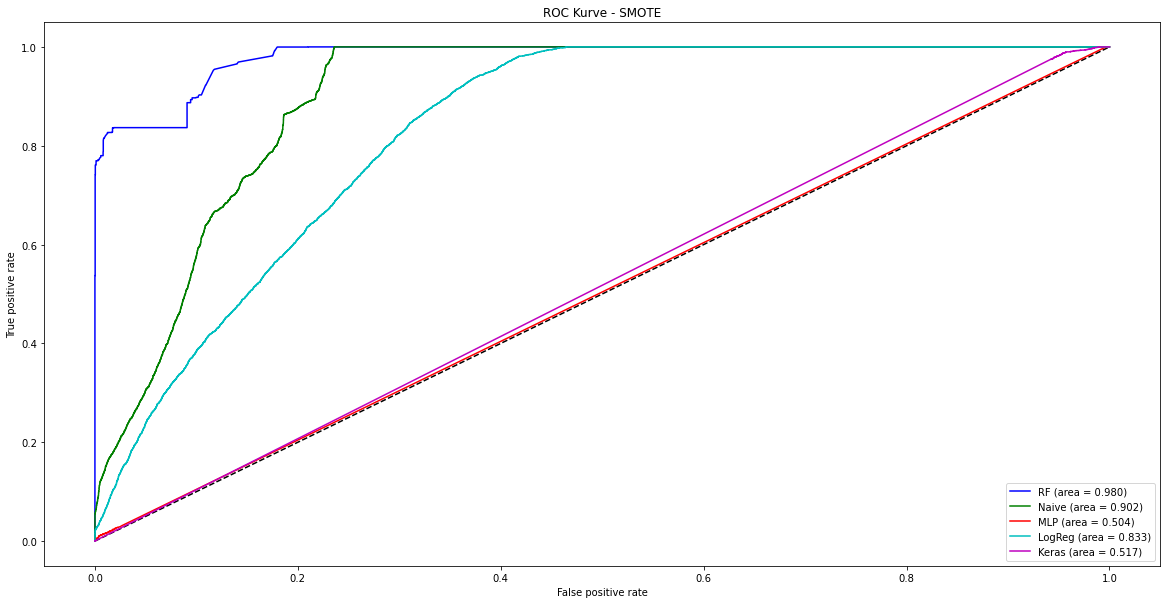

In [76]:
plt.figure(figsize = (20, 10))
plt.plot([0, 1], [0, 1], 'k--')
#plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
plt.plot(fpr_rf, tpr_rf, "b", label='RF (area = {:.3f})'.format(auc_rf))
plt.plot(fpr_nb, tpr_nb, "g", label='Naive (area = {:.3f})'.format(auc_nb))
plt.plot(fpr_mlp, tpr_mlp, "r", label='MLP (area = {:.3f})'.format(auc_mlp))
plt.plot(fpr_log, tpr_log, "c", label='LogReg (area = {:.3f})'.format(auc_log))
plt.plot(fpr_keras, tpr_keras, "m", label='Keras (area = {:.3f})'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Kurve - SMOTE')
plt.legend(loc='best')
plt.savefig('roc_prod.png')
plt.show()



In [36]:
valid = valid.drop(["Split"], axis = 1)

In [45]:
predicted_valid = rf.predict_proba(valid)


In [43]:
def Find_Optimal_Cutoff(target, predicted):
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

threshold = Find_Optimal_Cutoff(y_test, y_pred_rf)

In [56]:
valid["predicted"] = predicted_valid[:,1]

In [61]:
threshold = float(threshold[0])

In [62]:
#valid["predicted"] = predicted_valid

valid["Label"] = ["True" if x > threshold else "False" for x in valid["predicted"]]

#[1500 if x =='Music' else 800 for x in df['Event']] 

In [64]:
valid["Label"].value_counts()

False    54590
True     19795
Name: Label, dtype: int64

In [65]:
new_df = valid[["Label", "predicted", "ProcessCycle"]]

In [67]:
true = new_df[new_df["Label"]=="True"]

In [74]:
true["ProcessCycle"].value_counts()

5     4186
1     3275
24    3016
4     2549
3     2508
2     2355
22     975
17     796
12      92
6       13
14       6
9        6
21       6
20       6
7        3
18       3
Name: ProcessCycle, dtype: int64